In [1]:
# Imports and plotting preferences
import os
import numpy as np
from sklearn.mixture import GMM
from astropy.io import fits
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

sns.set(style='white', font_scale=1.6, palette='deep')
col = sns.color_palette()

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# Class to read, write, and sample from a mixture model.
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covars_, name='covars'))
        hdus.writeto(filename, clobber=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [3]:
# Use the Bayesian information criterion to determine how many components we need.
def getbic(X, ncomp=[3]):
    bic = [GMM(n_components=nc, covariance_type="full").fit(X).bic(X) for nc in ncomp]
    #for ii in range(len(ncomp)):
    #    print(ncomp[ii], bic[ii])
    return bic

### Model the [OIII]/Hb, [OII]/Hb, [NII]/Hb, and [SII]/Hb emission-line sequences

In [4]:
# Output file name
forbid_mogfile = os.path.join(os.getenv('DESISIM'), 'data', 'forbidden_mogs.fits')

In [5]:
# Define the valid ranges. MoGs are sensitive to outliers.
oiiihbrange = (-1.5,1.0)
oiihbrange = (-1.2,1.2)
niihbrange = (-2.0,0.8)
siihbrange = (-2.0,0.4)

In [6]:
# Read the catalogs of emission-line objects we will use to calibrate the forbidden emission-line sequences: SDSS 
# (MPA/JHU DR7 catalog); HII region (Moustakas et al. 2010); and integrated spectral atlas data (from 
# Moustakas & Kennicutt 2006).
atlas = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','atlas-emlines.fits.gz'),1)
sdss = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','sdss-emlines.fits.gz'),1)
hii = fits.getdata(os.path.join(os.getenv('DESI_ROOT'),'data','hii-emlines.fits.gz'),1)

atlas = atlas[np.where((atlas['OIIIHB']>oiiihbrange[0])*(atlas['OIIIHB']<oiiihbrange[1])*
                       (atlas['OIIHB']>oiihbrange[0])*(atlas['OIIHB']<oiihbrange[1])*
                       (atlas['NIIHB']>niihbrange[0])*(atlas['NIIHB']<niihbrange[1])*
                       (atlas['SIIHB']>siihbrange[0])*(atlas['SIIHB']<siihbrange[1]))[0]]
sdss = sdss[np.where((sdss['OIIIHB']>oiiihbrange[0])*(sdss['OIIIHB']<oiiihbrange[1])*
                     (sdss['OIIHB']>oiihbrange[0])*(sdss['OIIHB']<oiihbrange[1])*
                     (sdss['NIIHB']>niihbrange[0])*(sdss['NIIHB']<niihbrange[1])*
                     (sdss['SIIHB']>siihbrange[0])*(sdss['SIIHB']<siihbrange[1]))[0]]
hii = hii[np.where((hii['OIIIHB']>oiiihbrange[0])*(hii['OIIIHB']<oiiihbrange[1])*
                   (hii['OIIHB']>oiihbrange[0])*(hii['OIIHB']<oiihbrange[1])*
                   (hii['NIIHB']>niihbrange[0])*(hii['NIIHB']<niihbrange[1])*
                   (hii['SIIHB']>siihbrange[0])*(hii['SIIHB']<siihbrange[1]))[0]]
print('N(atlas)={}, N(HII)={}, N(SDSS)={}'.format(len(atlas), len(hii), len(sdss)))

N(atlas)=188, N(HII)=619, N(SDSS)=93465


In [7]:
# Define some convenience variables.  I decide here to not use the SDSS in the fitting.
#oiiihb = np.concatenate((sdss['OIIIHB'], atlas['OIIIHB'], hii['OIIIHB'])).flatten()
#oiihb  = np.concatenate((sdss['OIIHB'], atlas['OIIHB'], hii['OIIHB'])).flatten()
#niihb  = np.concatenate((sdss['NIIHB'], atlas['NIIHB'], hii['NIIHB'])).flatten()
#siihb  = np.concatenate((sdss['SIIHB'], atlas['SIIHB'], hii['SIIHB'])).flatten()

oiiihb = np.concatenate((atlas['OIIIHB'], hii['OIIIHB'])).flatten()
oiihb  = np.concatenate((atlas['OIIHB'], hii['OIIHB'])).flatten()
niihb  = np.concatenate((atlas['NIIHB'], hii['NIIHB'])).flatten()
siihb  = np.concatenate((atlas['SIIHB'], hii['SIIHB'])).flatten()
Xall = np.array([oiiihb, oiihb, niihb, siihb]).T

print('Total number of objects = {}'.format(len(oiiihb)))

Total number of objects = 807


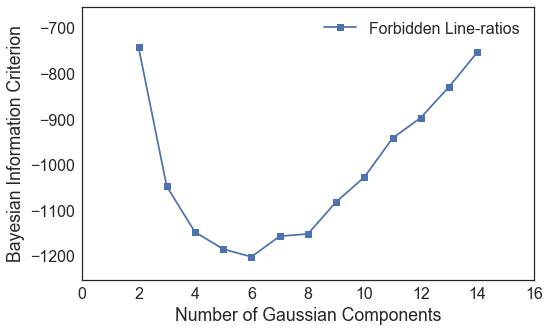

In [8]:
# Determine how many Gaussian components we need by looking at the Bayesian Information Criterion.
ncomp = np.arange(2,15)
bic = getbic(Xall, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
ax.set_xlim((0,16))
ax.set_ylim((-1250,-650))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.legend(labels=['Forbidden Line-ratios'])
plt.tight_layout()
plt.show()       

In [9]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 6 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xall)
print('Writing {}'.format(forbid_mogfile))
GaussianMixtureModel.save(mog, forbid_mogfile)

Writing /Users/ioannis/repos/git/desihub/desisim/data/forbidden_mogs.fits


In [10]:
# Reread the model.
mog = GaussianMixtureModel.load(forbid_mogfile)
samp = mog.sample(1000)

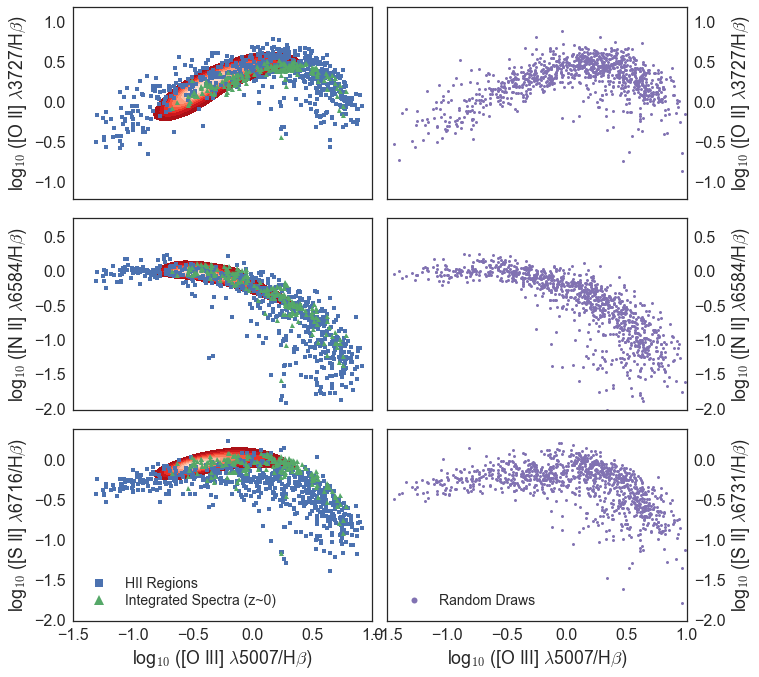

In [11]:
# Now plot the emission-line sequences of interest.  Show the data on the left-hand panels
# and random draws from the MoGs on the right-hand panels.
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11,11), 
                                                        sharex=True)
                                                    
# [OII]/Hbeta vs [OIII]/Hbeta
ax1.plot(hii['OIIIHB'], hii['OIIHB'], 's', markersize=4, label='HII Regions')
ax1.plot(atlas['OIIIHB'], atlas['OIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['OIIHB'], clip=(oiiihbrange, oiihbrange), ax=ax1, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax1.set_xlim(oiiihbrange)
ax1.set_ylim(oiihbrange)
ax1.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

ax2.plot(samp[:,0], samp[:,1], 'o', label='Random Draws', c=col[3], markersize=3)
ax2.set_xlim(oiiihbrange)
ax2.set_ylim(oiihbrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

# [NII]/Hbeta vs [OIII]/Hbeta
ax3.plot(hii['OIIIHB'], hii['NIIHB'], 's', markersize=4, label='HII Regions')
ax3.plot(atlas['OIIIHB'], atlas['NIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['NIIHB'], clip=(oiiihbrange, niihbrange), ax=ax3, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax3.set_xlim(oiiihbrange)
ax3.set_ylim(niihbrange)
ax3.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')

ax4.plot(samp[:,0], samp[:,2], 'o', label='Random Draws', c=col[3], markersize=3)
ax4.set_xlim(oiiihbrange)
ax4.set_ylim(niihbrange)
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')

# [SII]/Hbeta vs [OIII]/Hbeta
ax5.plot(hii['OIIIHB'], hii['SIIHB'], 's', markersize=4, label='HII Regions')
ax5.plot(atlas['OIIIHB'], atlas['SIIHB'], '^', markersize=5, label='Integrated Spectra (z~0)')
sns.kdeplot(sdss['OIIIHB'], sdss['SIIHB'], clip=(oiiihbrange, siihbrange), ax=ax5, gridsize=40,
           cmap="Reds_r", shade=True, cut=0, shade_lowest=False, label='SDSS')
ax5.set_xlim(oiiihbrange)
ax5.set_ylim(siihbrange)
ax5.set_ylabel(r'log$_{10}$ ([S II] $\lambda$6716/H$\beta$)')
ax5.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax5.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax6.plot(samp[:,0], samp[:,3], 'o', label='Random Draws', c=col[3], markersize=3)
ax6.set_xlim(oiiihbrange)
ax6.set_ylim(siihbrange)
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax6.set_ylabel(r'log$_{10}$ ([S II] $\lambda$6731/H$\beta$)')
ax6.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax6.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

In [12]:
# Show that the AGES (BGS) sample obeys the same emission-line distributions.
meta = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'bgs_templates_v2.0.fits'),1)

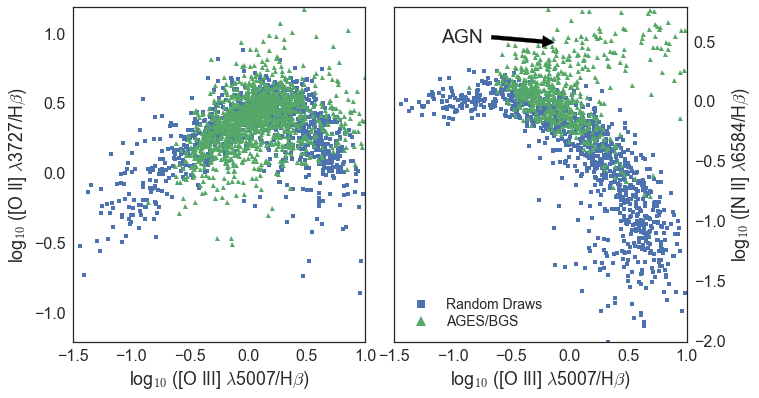

In [13]:
#fig, ax1 = plt.subplots(1, 1, figsize=(8,8))#, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,6))#, sharey=True)
                                 
# [OII]/Hbeta vs [OIII]/Hbeta
good = np.where((meta['OIIIHBETA']>-900)*(meta['OIIHBETA']>-900)*1)[0]
ax1.plot(samp[:,0], samp[:,1], 's', markersize=4)
ax1.plot(meta['OIIIHBETA'][good], meta['OIIHBETA'][good], '^', markersize=5)
ax1.set_xlim(oiiihbrange)
ax1.set_ylim(oiihbrange)
ax1.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax1.set_ylabel(r'log$_{10}$ ([O II] $\lambda$3727/H$\beta$)')

# [NII]/Hbeta vs [OIII]/Hbeta
good = np.where((meta['OIIIHBETA']>-900)*(meta['NIIHBETA']>-900)*1)[0]
ax2.plot(samp[:,0], samp[:,2], 's', markersize=4, label='Random Draws')
ax2.plot(meta['OIIIHBETA'][good], meta['NIIHBETA'][good], '^', markersize=5, label='AGES/BGS')
ax2.set_xlim(oiiihbrange)
ax2.set_ylim(niihbrange)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'log$_{10}$ ([N II] $\lambda$6584/H$\beta$)')
ax2.set_xlabel(r'log$_{10}$ ([O III] $\lambda$5007/H$\beta$)')
ax2.legend(loc='lower left', prop={'size': 14}, labelspacing=0.25, markerscale=2)

ax2.annotate('', xy=(-0.1, 0.5), xytext=(-0.7, 0.55),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax2.text(-1.1, 0.5, 'AGN')

fig.subplots_adjust(wspace=0.1)
plt.show()

### Calibrate the EW(H-beta) vs D(4000) sequence for the BGS using the AGES data.

In [14]:
# Output file name
bgs_mogfile = os.path.join(os.getenv('DESISIM'), 'data', 'bgs_mogs.fits')

In [15]:
# Read the BGS metadata.
meta = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'bgs_templates_v2.0.fits'),1)
meta.columns

ColDefs(
    name = 'TEMPLATEID'; format = 'J'
    name = 'PASS'; format = 'I'
    name = 'APER'; format = 'I'
    name = 'RA'; format = 'D'; unit = 'degrees'
    name = 'DEC'; format = 'D'; unit = 'degrees'
    name = 'Z'; format = 'E'
    name = 'WEIGHT'; format = 'E'
    name = 'AGES_INFIBER_R'; format = 'E'
    name = 'INFIBER_R'; format = 'E'
    name = 'INFIBER_I'; format = 'E'
    name = 'VDISP'; format = 'E'
    name = 'SIGMA_KMS'; format = 'E'; unit = 'km/s'
    name = 'HBETA'; format = 'E'
    name = 'HBETA_EW'; format = 'E'
    name = 'HBETA_LIMIT'; format = 'I'
    name = 'HALPHAHBETA'; format = 'E'
    name = 'OIIIHBETA'; format = 'E'
    name = 'OIIHBETA'; format = 'E'
    name = 'NIIHBETA'; format = 'E'
    name = 'HBETA_CONTINUUM'; format = 'E'
    name = 'LOGMSTAR'; format = 'E'; unit = 'Msun'
    name = 'LOGSFR'; format = 'E'; unit = 'Msun/yr'
    name = 'AV_ISM'; format = 'E'; unit = 'mag'
    name = 'D4000'; format = 'E'
    name = 'D4000_SPEC'; format = 'E'
)

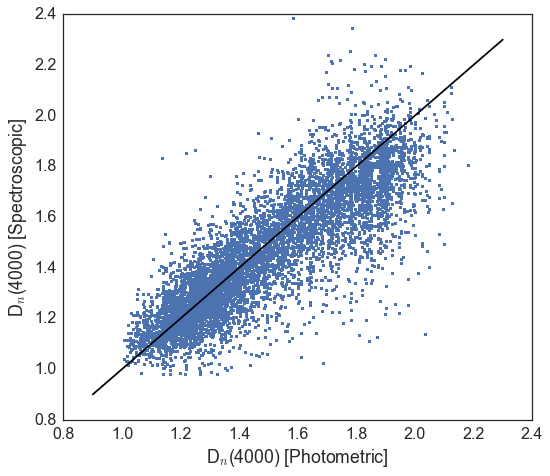

In [16]:
# Show that the photometric and spectroscopic D(4000) values match nicely.
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.plot(meta['D4000'], meta['D4000_SPEC'], marker='s', markersize=3, linestyle='None')
ax.plot([0.9,2.3], [0.9,2.3], color='k')
ax.set_xlim((0.8,2.4))
ax.set_ylim((0.8,2.4))
ax.set_xlabel('D$_{n}$(4000) [Photometric]')
ax.set_ylabel('D$_{n}$(4000) [Spectroscopic]')
plt.tight_layout()
plt.show()       

In [17]:
# Separate out galaxies with well-measured H-beta vs upper limits.
good = np.where(meta['HBETA_LIMIT']==0)[0]
limit = np.where(meta['HBETA_LIMIT']==1)[0]
Xages = np.array((meta['D4000'][good], np.log10(meta['HBETA_EW'][good]))).T
Xageslim = np.array((meta['D4000'][limit], np.log10(meta['HBETA_EW'][limit]))).T

In [18]:
# Model the distribution with a simple polynomial.
bgscoeff = np.polyfit(Xages[:,0], Xages[:,1], 2)
print(bgscoeff)

[ 1.28520974 -4.94408026  4.9617704 ]


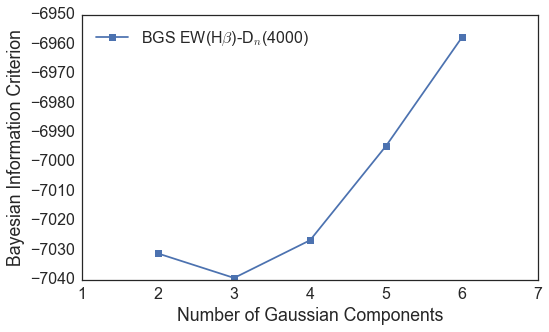

In [19]:
ncomp = np.arange(2,7)
bic = getbic(Xages, ncomp)
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(ncomp, bic, marker='s', ls='-')
plt.legend(labels=[r'BGS EW(H$\beta$)-D$_{n}$(4000)'], loc='upper left')
ax.set_xlim((1,ncomp.max()+1))
ax.set_xlabel('Number of Gaussian Components')
ax.set_ylabel('Bayesian Information Criterion')
plt.tight_layout()
plt.show()       

In [20]:
# Model the distribution using a mixture of Gaussians and write out.
ncomp = 3 # from figure above
mog = GMM(n_components=ncomp, covariance_type="full").fit(Xages)
print('Writing {}'.format(bgs_mogfile))
GaussianMixtureModel.save(mog, bgs_mogfile)

Writing /Users/ioannis/repos/git/desihub/desisim/data/bgs_mogs.fits


In [21]:
# Reread the model.
mog = GaussianMixtureModel.load(bgs_mogfile)
samp = mog.sample(1000)

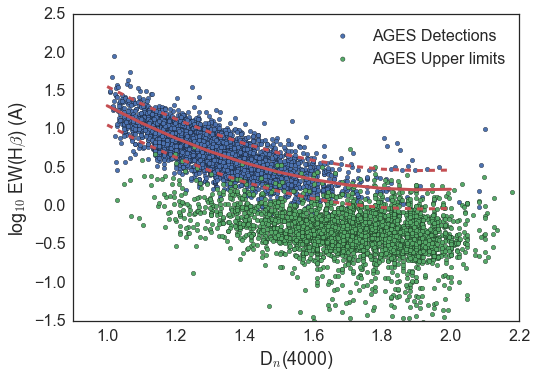

In [22]:
# Make a plot.
d4000axis = np.arange(1.0, 2.1, 0.1)
ewhbetafit = np.polyval(bgscoeff, d4000axis)

plt.scatter(Xages[:,0], Xages[:,1], c=col[0], label='AGES Detections')
plt.scatter(Xageslim[:,0], Xageslim[:,1], c=col[1], label='AGES Upper limits')
#plt.scatter(samp[:,0], samp[:,1], c=col[4], label='Random Draws')
plt.plot(d4000axis, ewhbetafit, lw=3, c=col[2])
plt.plot(d4000axis, ewhbetafit+0.25, ls='--', lw=3, c=col[2])
plt.plot(d4000axis, ewhbetafit-0.25, ls='--', lw=3, c=col[2])
plt.xlabel('D$_{n}$(4000)')
plt.ylabel(r'log$_{10}$ EW(H$\beta$) (A)')
plt.xlim((0.9,2.2))
plt.ylim((-1.5,2.5))
plt.legend()
plt.show()

### Calibrate the EW([OII]) vs D(4000) sequence for DEEP2 ELGs.

In [23]:
# Read the ELG metadata.
meta = fits.getdata(os.path.join(os.getenv('DESI_BASIS_TEMPLATES'),'elg_templates_v2.0.fits'),1)
meta.columns

ColDefs(
    name = 'TEMPLATEID'; format = 'J'
    name = 'OBJNO'; format = 'J'
    name = 'RA'; format = 'D'; unit = 'degrees'
    name = 'DEC'; format = 'D'; unit = 'degrees'
    name = 'Z'; format = 'E'
    name = 'MAGB'; format = 'E'
    name = 'MAGR'; format = 'E'
    name = 'MAGI'; format = 'E'
    name = 'DECAM_G'; format = 'E'
    name = 'DECAM_R'; format = 'E'
    name = 'DECAM_Z'; format = 'E'
    name = 'W1'; format = 'E'
    name = 'W2'; format = 'E'
    name = 'SIGMA_KMS'; format = 'E'; unit = 'km/s'
    name = 'OII_3726'; format = 'E'; unit = 'erg/s/cm2'
    name = 'OII_3729'; format = 'E'; unit = 'erg/s/cm2'
    name = 'OII_3727'; format = 'E'; unit = 'erg/s/cm2'
    name = 'OII_3727_EW'; format = 'E'; unit = 'Angstrom'
    name = 'OII_CONTINUUM'; format = 'E'; unit = 'erg/s/cm2'
    name = 'RADIUS_HALFLIGHT'; format = 'E'; unit = 'arcsec'
    name = 'SERSICN'; format = 'E'
    name = 'AXIS_RATIO'; format = 'E'
    name = 'LOGMSTAR'; format = 'E'; unit = 'Msun'
    name 

In [24]:
# Convenience variables
from desitarget.cuts import isELG
elg = isELG(gflux=10**(0.4*(22.5-meta['DECAM_G'])), rflux=10**(0.4*(22.5-meta['DECAM_R'])), 
            zflux=10**(0.4*(22.5-meta['DECAM_Z'])))
X = np.array((meta['D4000'], np.log10(meta['OII_3727_EW']))).T
Xelg = np.array((meta['D4000'][elg], np.log10(meta['OII_3727_EW'][elg]))).T
Xelg

array([[ 1.07184112,  1.93415534],
       [ 1.08197808,  1.78979087],
       [ 1.03892148,  1.55228555],
       ..., 
       [ 1.0101943 ,  1.07338357],
       [ 0.98913455,  1.80987275],
       [ 1.03170979,  1.57112086]], dtype=float32)

In [25]:
# Model the distribution with a simple polynomial.
elgcoeff = np.polyfit(X[:,0], X[:,1], 2)
print(elgcoeff)

[ 1.34323087 -5.02866474  5.43842874]


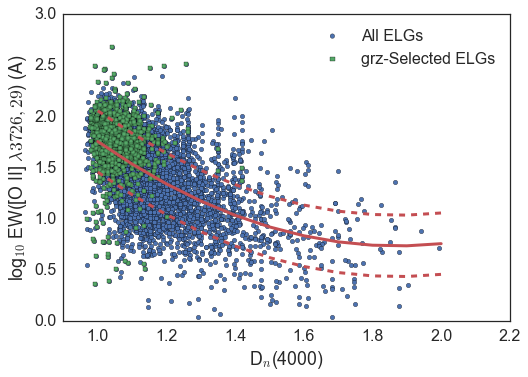

In [26]:
# Make a plot.
d4000axis = np.arange(1.0, 2.1, 0.1)
ewoiifit = np.polyval(elgcoeff, d4000axis)

plt.scatter(X[:,0], X[:,1], c=col[0], label='All ELGs')
plt.scatter(Xelg[:,0], Xelg[:,1], c=col[1], marker='s', label='grz-Selected ELGs')
plt.plot(d4000axis, ewoiifit, lw=3, c=col[2])
plt.plot(d4000axis, ewoiifit+0.3, ls='--', lw=3, c=col[2])
plt.plot(d4000axis, ewoiifit-0.3, ls='--', lw=3, c=col[2])
plt.xlabel('D$_{n}$(4000)')
plt.ylabel(r'log$_{10}$ EW([O II] $\lambda3726,29$) (A)')
plt.xlim((0.9,2.2))
plt.ylim((0.0,3))
plt.legend()
plt.show()